# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import TrimAfterTrigger, apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  16000


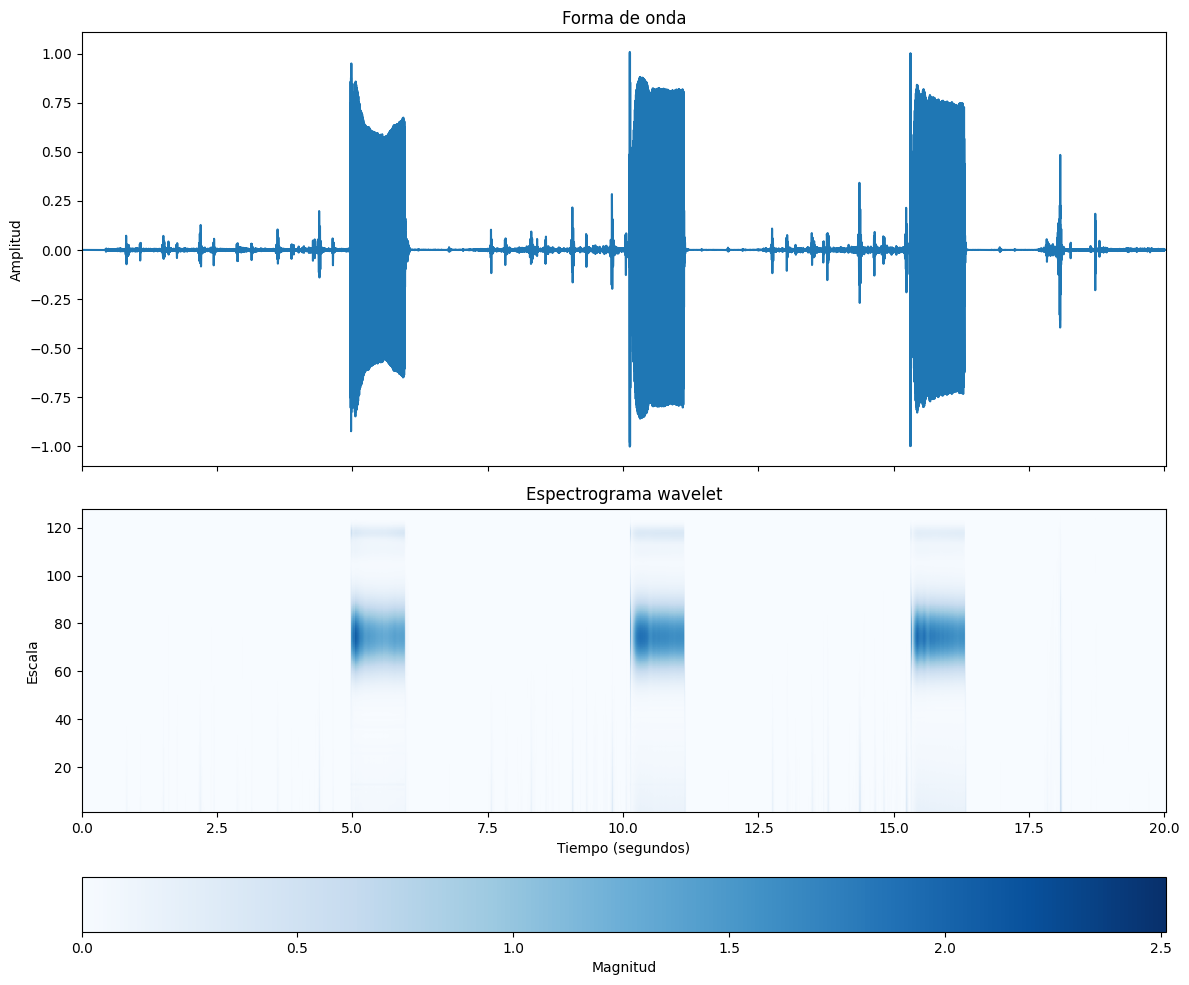

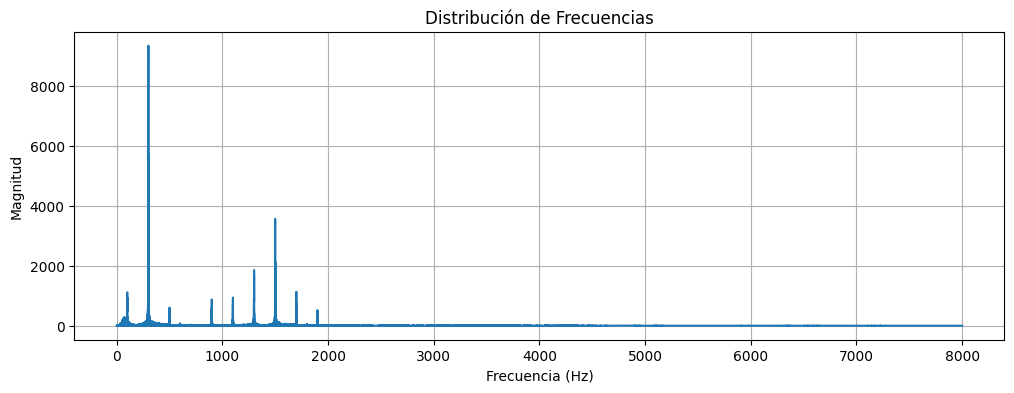

In [2]:
AUDIO_NAME = "test-202407211616.m4a"
audio_DIR = get_base_dir().joinpath(f"data/mobile/{AUDIO_NAME}")

audio, sample_rate = torchaudio.load(str(audio_DIR))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Resample to match the digital stethoscope sample rate

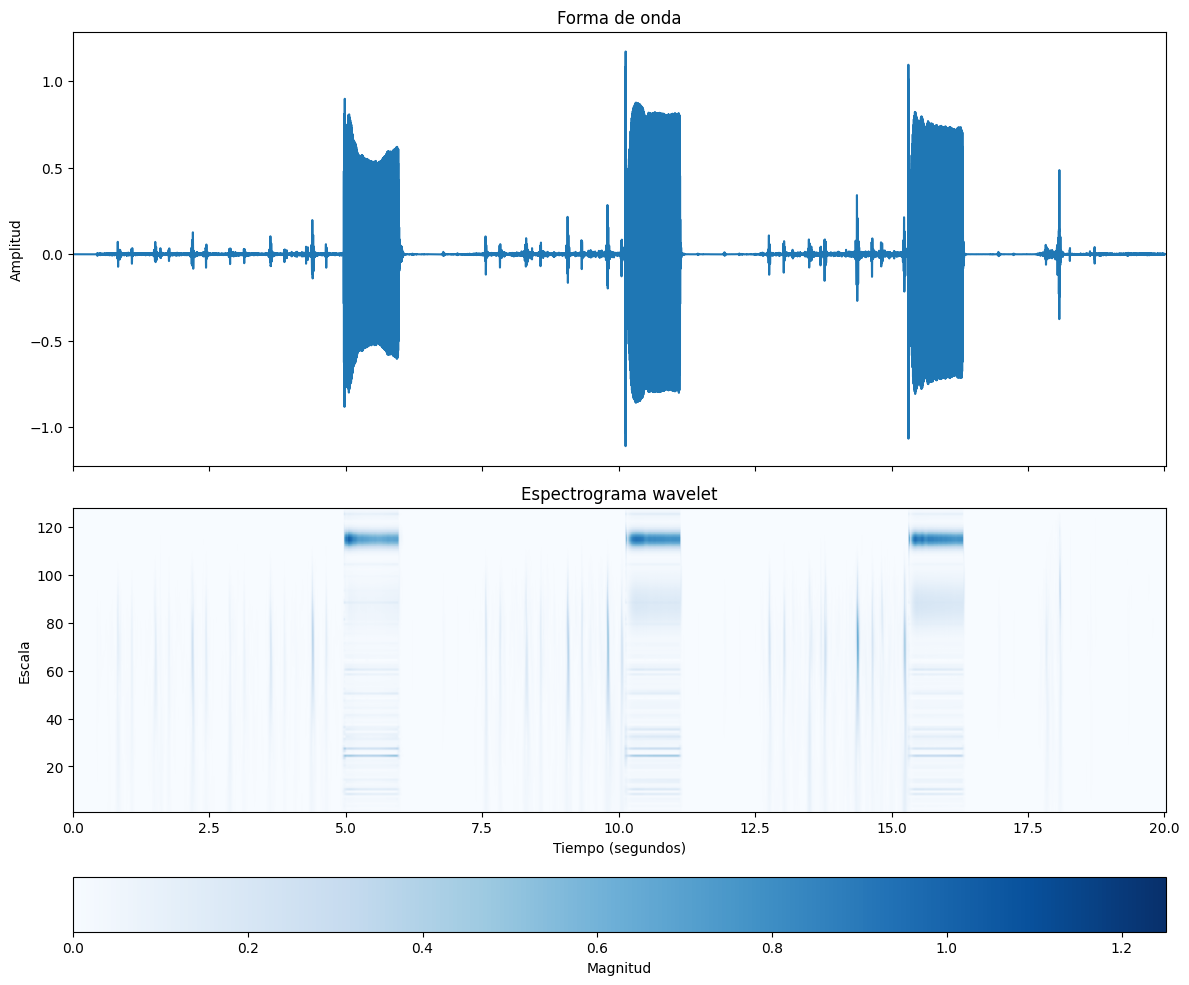

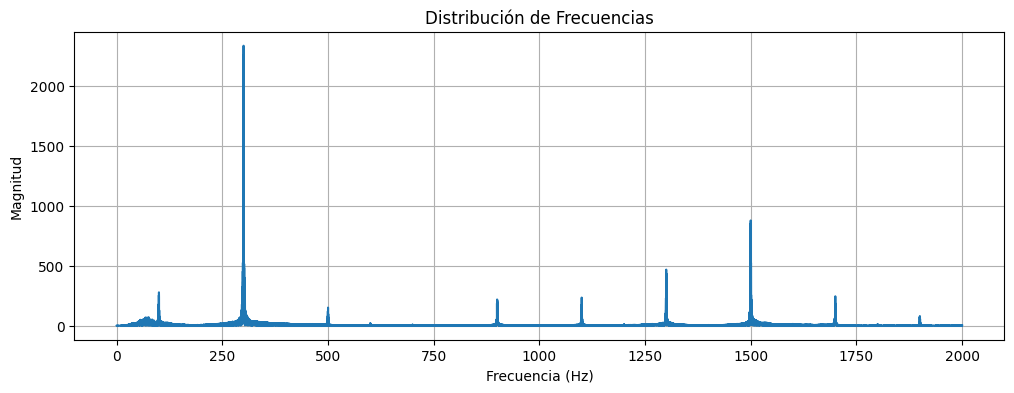

In [3]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)

audio = resampler(audio)
sample_rate = new_sample_rate

plot_wavelet_spectrogram(audio.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

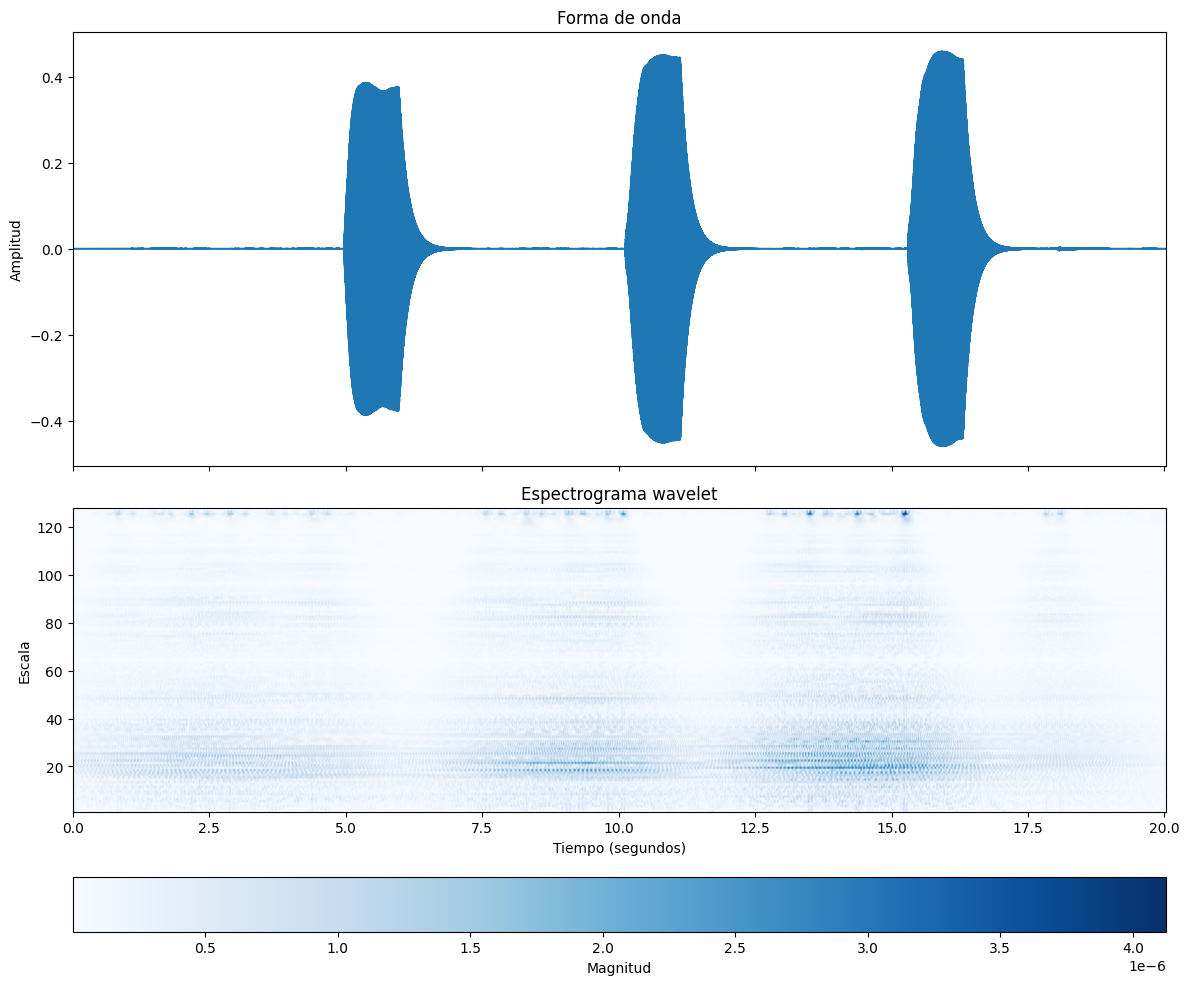

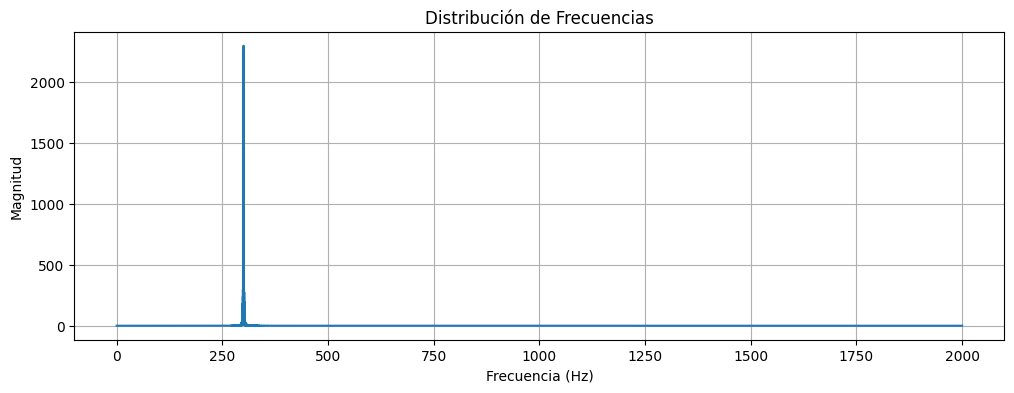

In [4]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    audio, sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Downsample and smooth it

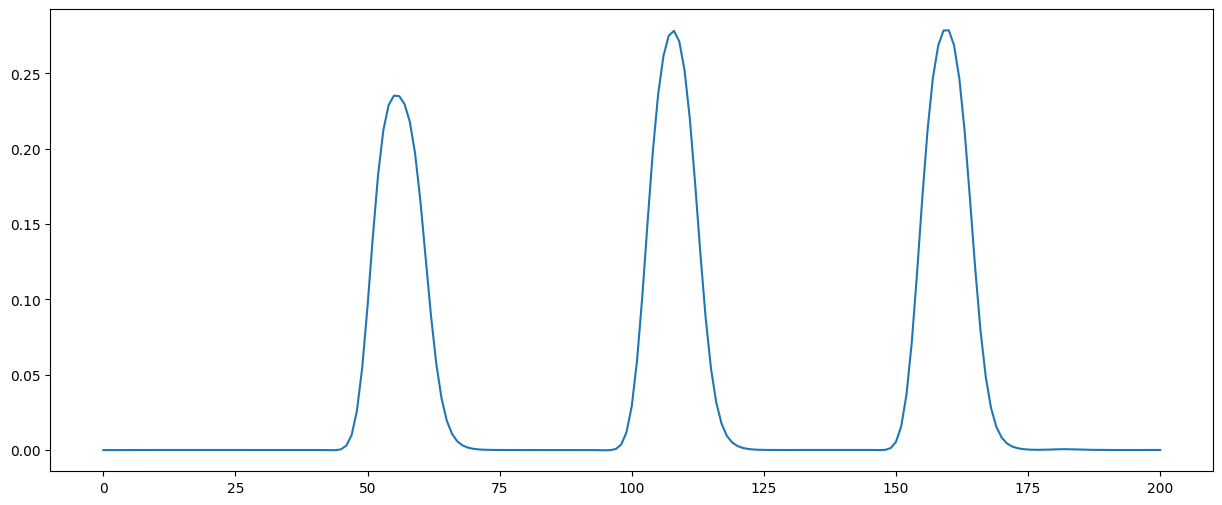

In [5]:
tat = TrimAfterTrigger()
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 2

smoothed = tat.abs_downsample_smooth(filtered_audio, DOWNSAMPLE_FACTOR, SIGMA_SMOOTH)
plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

Audio(smoothed, rate=sample_rate / DOWNSAMPLE_FACTOR, autoplay=True)

# Find peaks where signal changes

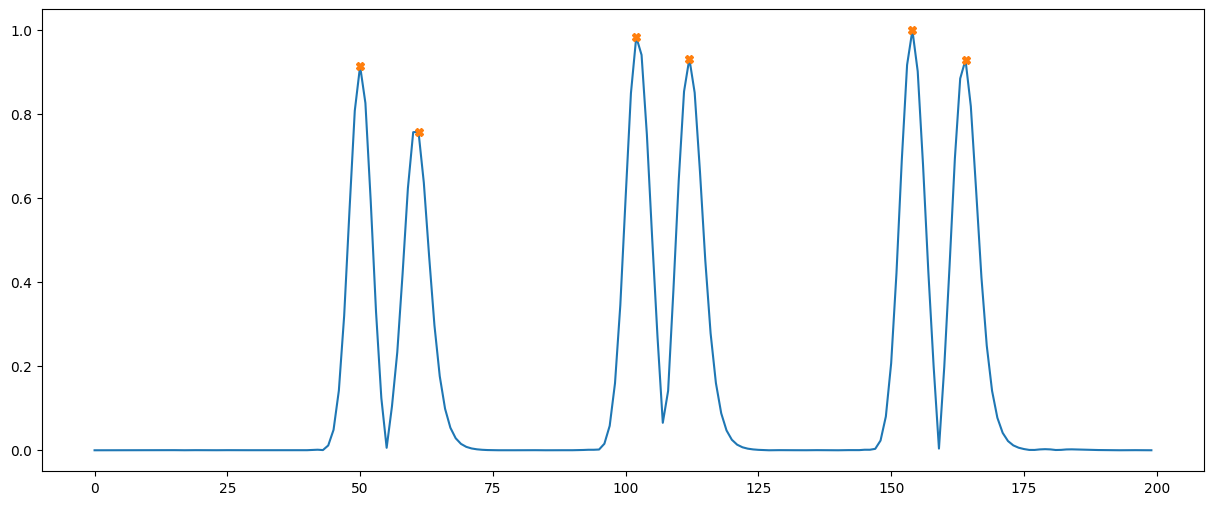

In [6]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 50  61 102 112 154 164]
Peaks in real signal: [20000 24400 40800 44800 61600 65600]


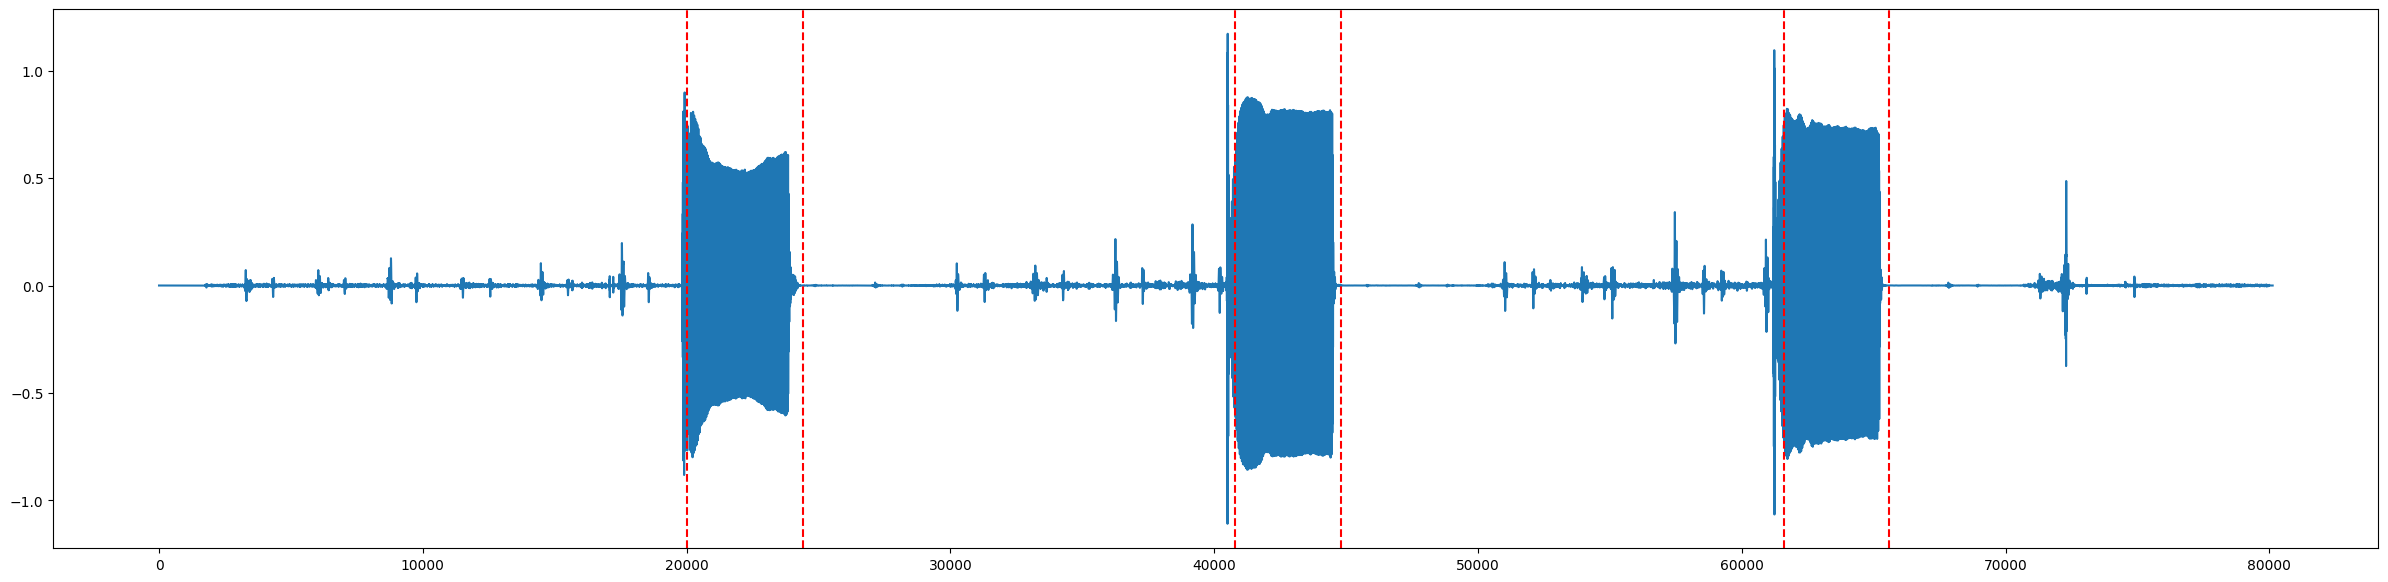

In [7]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.show()

# Adjust peaks to make sure the trigger is considered.

In [8]:
print(f"Peaks: {upsampled_peaks}")

segment_duration = np.diff(upsampled_peaks) / sample_rate
print(f"Duration (without the first one): {segment_duration}")

is_peak_start = np.concatenate([segment_duration < 2, [False]])
is_peak_end = np.concatenate([[False], segment_duration < 2])

peak_starts = upsampled_peaks[is_peak_start]
peak_ends = upsampled_peaks[is_peak_end]

print(f"Peak starts on: {peak_starts}")
print(f"Peak ends on: {peak_ends}")

Peaks: [20000 24400 40800 44800 61600 65600]
Duration (without the first one): [1.1 4.1 1.  4.2 1. ]
Peak starts on: [20000 40800 61600]
Peak ends on: [24400 44800 65600]


In [9]:
TRIGGER_DURATION = 1
duration_adj = TRIGGER_DURATION + 0.1

trigger_starts = []
trigger_ends = []

for start, end in zip(peak_starts, peak_ends):
    raw_duration = (end - start) / sample_rate
    duration_diff = duration_adj - raw_duration
    half_diff = duration_diff / 2

    to_adjust = half_diff * sample_rate

    trigger_starts.append(start - to_adjust)
    trigger_ends.append(end + to_adjust)

print(f"Trigger starts on: {trigger_starts}")
print(f"Trigger ends on: {trigger_ends}")

new_duration = [(end - start) / sample_rate for start, end in zip(trigger_starts, trigger_ends)]
print(f"With duration adjusted to: {new_duration}")

Trigger starts on: [20000.0, 40600.0, 61400.0]
Trigger ends on: [24400.0, 45000.0, 65800.0]
With duration adjusted to: [1.1, 1.1, 1.1]


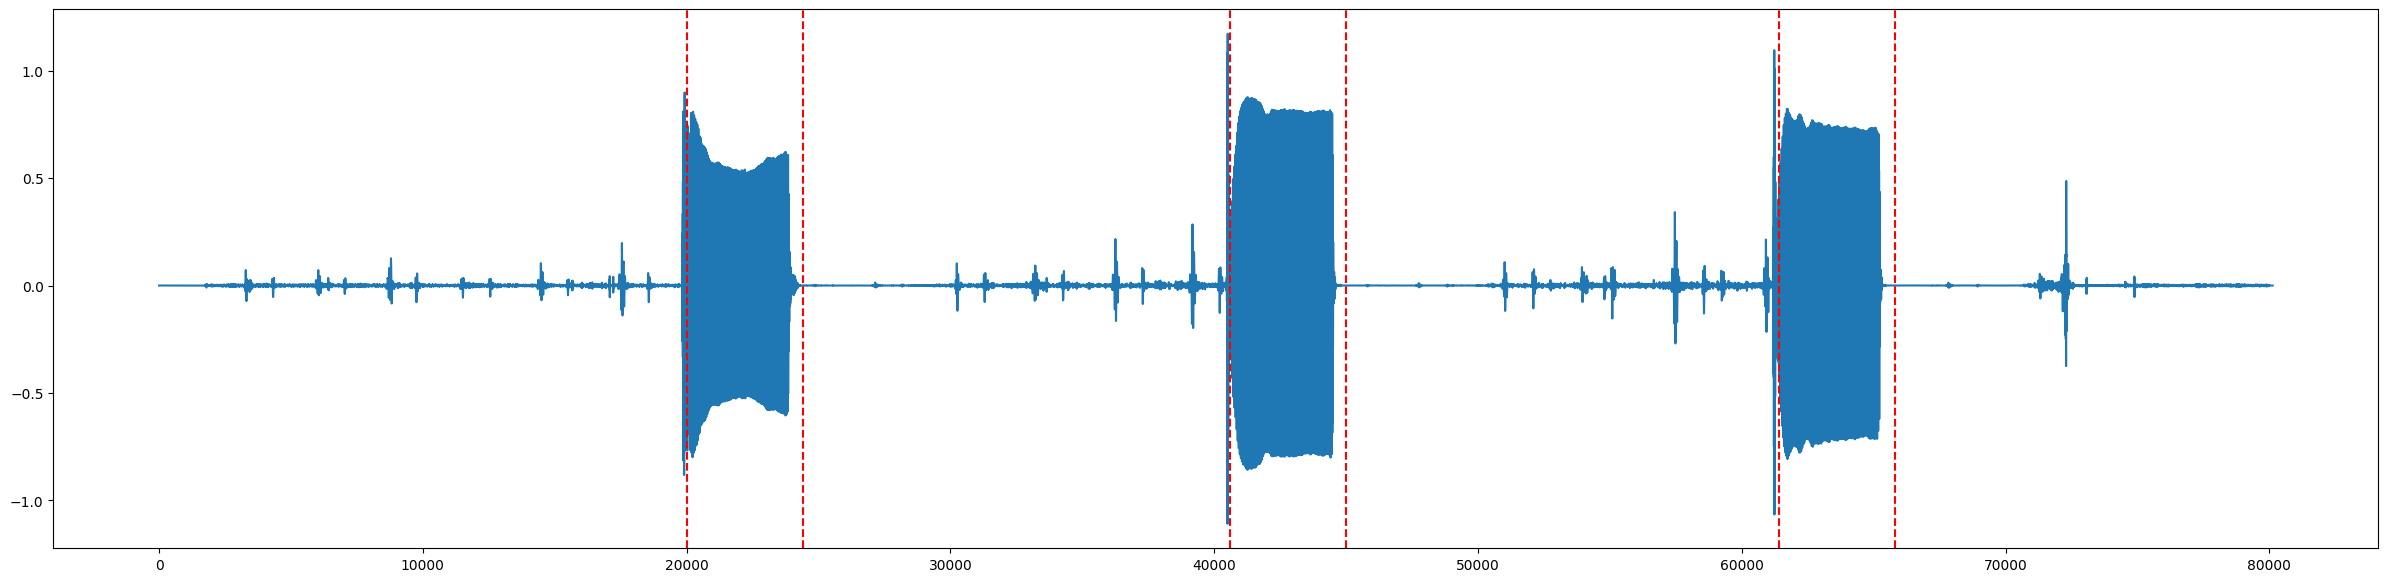

In [10]:
plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for start, end in zip(trigger_starts, trigger_ends):
    plt.axvline(x=start, color='red', linestyle='--')
    plt.axvline(x=end, color='red', linestyle='--')

plt.show()

# Split signal

In [11]:
new_peaks = np.array(sorted(trigger_starts + trigger_ends)).astype(int)
new_peaks

array([20000, 24400, 40600, 45000, 61400, 65800])

In [12]:
split_points = np.concatenate(([0], new_peaks, [audio.shape[1]]))

audio_tensor = audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / sample_rate
    to_print = f"#{i+1} ({duration:.2f}s)"

    if duration == duration_adj:
        to_print += " trigger"
    else:
        to_print += " segment"

    to_print += f": {segment}"
    print(to_print)

#1 (5.00s) segment: tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.4547, -0.1136, -0.6006])
#2 (1.10s) trigger: tensor([-4.4300e-01,  1.3170e-01, -1.1312e-01,  ..., -6.2570e-05,
         9.0681e-05, -8.6136e-05])
#3 (4.05s) segment: tensor([ 1.5557e-05,  1.4525e-05,  1.5440e-04,  ..., -1.8058e-01,
        -1.4560e-01, -8.9863e-02])
#4 (1.10s) trigger: tensor([-2.3942e-01, -4.5482e-02,  1.2183e-02,  ..., -1.7732e-04,
        -1.5701e-04, -2.6631e-04])
#5 (4.10s) segment: tensor([-2.3948e-04, -2.3008e-04, -3.0927e-04,  ..., -1.7768e-01,
        -2.3442e-01, -1.6883e-01])
#6 (1.10s) trigger: tensor([-3.5847e-01, -1.7613e-01, -3.6065e-02,  ..., -3.1769e-04,
        -3.1048e-04, -3.1168e-04])
#7 (3.58s) segment: tensor([-3.1456e-04, -3.3870e-04, -3.3462e-04,  ..., -1.7305e-05,
        -2.3446e-05, -1.5826e-05])


# Keep just the valid segments

#1 (5.0s): tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.4547, -0.1136, -0.6006])


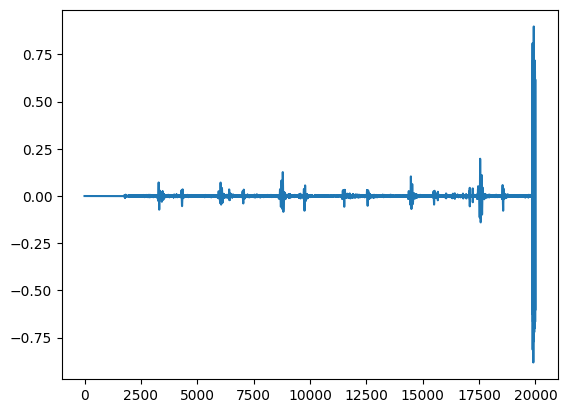

#2 (4.05s): tensor([ 1.5557e-05,  1.4525e-05,  1.5440e-04,  ..., -1.8058e-01,
        -1.4560e-01, -8.9863e-02])


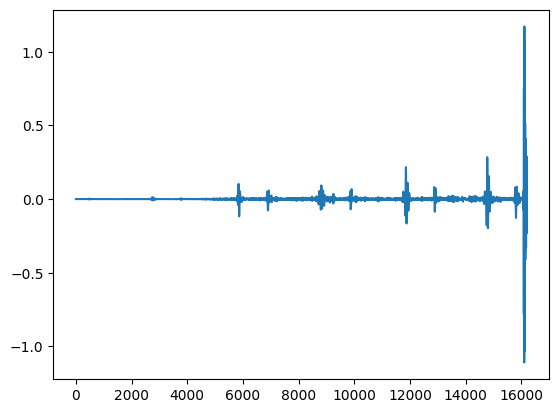

#3 (4.1s): tensor([-2.3948e-04, -2.3008e-04, -3.0927e-04,  ..., -1.7768e-01,
        -2.3442e-01, -1.6883e-01])


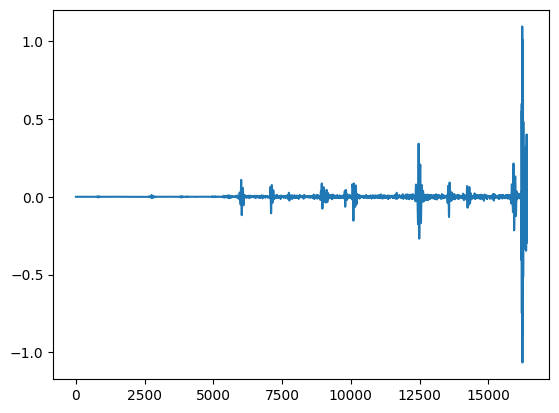

#4 (3.582s): tensor([-3.1456e-04, -3.3870e-04, -3.3462e-04,  ..., -1.7305e-05,
        -2.3446e-05, -1.5826e-05])


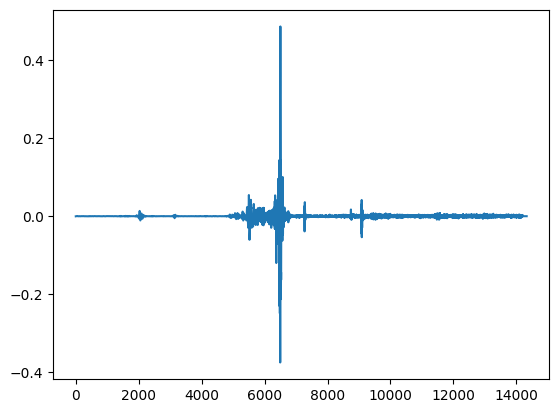

In [13]:
MIN_SECS = 3

filtered_segments = filter(lambda x: len(x) / sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

In [ ]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=audio_DIR,
    sample_rate_target=new_sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()